In [2]:
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
import pandas as pd
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired
import torch
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
from gensim import corpora
from langdetect import detect_langs, LangDetectException
import os
import glob
import gc
import pickle
from sklearn.metrics.pairwise import cosine_similarity
import plotly.graph_objects as go  # Import plotly's graph objects
from typing import List, Union
from IPython.display import display, HTML
os.environ["TOKENIZERS_PARALLELISM"] = "false"

/opt/homebrew/anaconda3/envs/landscape/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [124]:
os.chdir('/Users/lhampton/Documents/Local_Projects/ailandscapeproject')

In [3]:
os.chdir('/Users/lhampton/Library/CloudStorage/GoogleDrive-lucyjhampton5@gmail.com/.shortcut-targets-by-id/1EznD-uaTblXtaIVx04-toZMQh7cQf9hA/AI Landscape Large Files/Data/constructed/combined_topic_modeling')
constr_wp_dir = '/Users/lhampton/Library/CloudStorage/GoogleDrive-lucyjhampton5@gmail.com/.shortcut-targets-by-id/1EznD-uaTblXtaIVx04-toZMQh7cQf9hA/AI Landscape Large Files/Data/constructed/wp_classification'
constr_pub_dir = '/Users/lhampton/Library/CloudStorage/GoogleDrive-lucyjhampton5@gmail.com/.shortcut-targets-by-id/1EznD-uaTblXtaIVx04-toZMQh7cQf9hA/AI Landscape Large Files/Data/constructed/pub_classification'
orig_wp_dir = "/Users/lhampton/Library/CloudStorage/GoogleDrive-lucyjhampton5@gmail.com/.shortcut-targets-by-id/1EznD-uaTblXtaIVx04-toZMQh7cQf9hA/AI Landscape Large Files/Data/original/working_papers"
orig_pub_dir = "/Users/lhampton/Library/CloudStorage/GoogleDrive-lucyjhampton5@gmail.com/.shortcut-targets-by-id/1EznD-uaTblXtaIVx04-toZMQh7cQf9hA/AI Landscape Large Files/Data/original/published_papers"

## Load the data

In [5]:
pub_data_full = pd.read_csv(f"{orig_pub_dir}/no_duplicates.csv", index_col = 0).reset_index()
pub_data_full = pub_data_full[['Abstract', 'Article Title', 'Authors or Inventors']]
pub_data_full = pub_data_full.rename(columns = {'Abstract': 'abstract', 'Authors or Inventors' : 'author', 'Article Title': 'title'})

data = pd.read_csv(f'{constr_pub_dir}/relevant_pubs.csv', index_col = 0)
data = data[['Abstract', 'DOI', 'Cited by', 'Publication Year']]
data = data.rename(columns={'Abstract': 'abstract'})

data = pd.merge(data, pub_data_full, on = 'abstract', how = 'left')
data

,abstract,DOI,Cited by,Publication Year,title,author
0,"For employees, work involves taking breaks as ...",10.4018/JOEUC.329596,1,2023,The Shape of Workbreaks to Come: Reframing Cyb...,Oravec J.A.
1,The term 'artificial intelligence' (AI) refers...,10.1109/ICONSTEM60960.2024.10568724,0,2024,A Novel Approach of Data-Driven Strategic Deci...,Umamaheswari S.; Valarmathi A.; Dhinakaran D.P...
2,This study aims to explore how firms' innovati...,10.1504/IJTM.2020.112122,5,2020,How to become the chosen one in the artificial...,Li J.; Liu Z.; Zhou J.
3,This research aims to investigate the acceptan...,10.4018/IJEBR.323796,0,2023,A Study of Customer Acceptance of Artificial I...,Choi Y.
4,Generative AI appears poised to transform whit...,10.1145/3630106.3658987,0,2024,The Impact and Opportunities of Generative AI ...,Wolfe R.; Mitra T.
...,...,...,...,...,...,...
3594,"Since the introduction of ChatGPT, the leading...",10.1016/j.jbusres.2024.114720,2,2024,Artificial intelligence and consumer behavior:...,Hermann E.; Puntoni S.
3595,IBM has deployed its Predictive Analytics for ...,10.1287/INTE.2020.1064,1,2021,IBM predictive analytics reduces server downtime,Bogojeska J.; Giurgiu I.; Stark G.; Wiesmann D.
3596,Natural resources have long been considered a ...,10.1016/j.resourpol.2024.104831,0,2024,Nonlinear relationship between natural resourc...,Xie T.; Xu Y.; Li Y.
3597,Purpose: This study aims to explore the role t...,10.1108/IJRDM-12-2022-0493,7,2023,The role of artificial intelligence in improvi...,Calvo A.V.; Franco A.D.; Frasquet M.


In [165]:
# Remove non-english abstracts
def is_english(text, threshold=0.60):
    """
    Determines whether a text is predominantly English.

    Parameters:
      text (str): The text to analyse.
      threshold (float): The minimum total probability for English for the text to be considered English.

    Returns:
      bool: True if the cumulative probability of English is at least the threshold, otherwise False.
    """
    try:
        # Skip empty or missing abstracts
        if pd.isna(text) or text.strip() == '':
            return False
        # Obtain the list of detected languages with their probabilities
        lang_probs = detect_langs(text)
        # Calculate the total probability of the text being English
        en_prob = sum(lang.prob for lang in lang_probs if lang.lang == 'en')
        return en_prob >= threshold
    except LangDetectException:
        # If there is an error during language detection, assume it's not English
        return False
    
# apply to first 50 words of each abstract
data['Abstract_Short'] = data['abstract'].apply(lambda x: ' '.join(str(x).split()[:50]) if pd.notna(x) else '')
english_mask = data['Abstract_Short'].apply(lambda x: is_english(x) if pd.notna(x) else False)

# apply to last 50 words of each abstract
data['Abstract_Short_last'] = data['abstract'].apply(lambda x: ' '.join(str(x).split()[-50:]) if pd.notna(x) else '')
english_mask_last = data['Abstract_Short_last'].apply(lambda x: is_english(x) if pd.notna(x) else False)

# Create a dataframe of non-English abstracts
non_english_abstracts = data[~(english_mask & english_mask_last)][['abstract', 'Abstract_Short']]

# Print the short abstracts of all removed papers
print("Short abstracts of removed non-English papers:")
for idx, row in non_english_abstracts.iterrows():
    print(f"Index {idx}: {row['abstract']}")

print(f"Removing {len(data) - len(data[english_mask & english_mask_last])} non-English abstracts")
data = data[english_mask & english_mask_last]
data.reset_index(drop=True, inplace=True)

Short abstracts of removed non-English papers:
Index 792: În ultima perioadă, au avut loc schimbări semnificative în piața muncii și în viața angajaților, întrucât societatea modernă se adaptează din ce în ce mai ușor la implementarea instrumentelor de inteligență artificială. Cu toate acestea, schimbările tehnologice au creat și provocări, inclusiv un decalaj între competențele disponibile și cele necesare în utilizarea tehnologiilor de inteligență artificială. Acest studiu are drept scop analiza relațiilor dintre competențele angajaților și eficacitatea în utilizarea instrumentelor de inteligență artificială, pentru a pune în evidență setul de competențe esențiale în interacțiunea eficiență cu tehnologia de inteligență artificială. Astfel, pentru a atinge scopul cercetării a fost realizat un chestionar online care a fost completat de 209 angajați din România în perioada August -Septembrie 2023, iar pentru analiza datelor, au fost aplicate două tehnici avansate: modelarea cu ecuații s

In [166]:
# Define docs

documents = data['abstract']
documents = documents.reset_index(drop=True)
documents = documents.tolist()
documents = [str(doc) for doc in documents if isinstance(doc, str)]

## Setup Topic Model

### Compute embeddings

In [167]:
# Setup GPU and Embedder

# Check if MPS (Metal Performance Shaders) is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Metal Performance Shaders) for GPU acceleration")
    print(f"PyTorch version: {torch.__version__}")
    print(f"Current device: {device}")
    print(f"MPS device available: {torch.backends.mps.is_available()}")
    print(f"MPS device built: {torch.backends.mps.is_built()}")
else:
    device = torch.device("cpu")
    print("MPS not available, using CPU")

# Setup GPU Embedder
class GPUEmbedder:
    def __init__(self, model_name="all-roberta-large-v1"):
        self.model = SentenceTransformer(model_name).to(device)
        print(f"Model loaded on device: {next(self.model.parameters()).device}")
        
    def __call__(self, documents):
        return self.model.encode(documents, show_progress_bar=True)

# Initialize the embedding model and generate embeddings
print("\nInitializing embedder and generating embeddings...")
embedder = GPUEmbedder()
embeddings = embedder(documents)
embeddings = embeddings.astype(np.float64)
print(f"Embeddings shape: {embeddings.shape}")
print("Embeddings generated successfully!")

Using MPS (Metal Performance Shaders) for GPU acceleration
PyTorch version: 2.6.0
Current device: mps
MPS device available: True
MPS device built: True

Initializing embedder and generating embeddings...
Model loaded on device: mps:0


Batches: 100%|██████████| 113/113 [02:16<00:00,  1.21s/it]

Embeddings shape: (3592, 1024)
Embeddings generated successfully!


### Define topic model

In [168]:
# function for getting topic model
def create_topic_model(documents, min_cluster_size, embeddings):
  hdbscan_model = HDBSCAN(
    min_cluster_size=min_cluster_size,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,
    core_dist_n_jobs=-1
  )

  umap_model = UMAP(
    n_neighbors=15, 
    n_components=5, 
    metric='cosine', 
    random_state=42, 
    low_memory=False,  # Set to False for GPU usage
    n_jobs=-1
   )

  # Initialise the BERTopic model
  topic_model = BERTopic(
      embedding_model=None,
      umap_model=umap_model,
      hdbscan_model=hdbscan_model,
      vectorizer_model=CountVectorizer(stop_words="english")
  )

  # Fit the model on your data
  topics, probs = topic_model.fit_transform(documents, embeddings)

  # return topics, probs, topic model
  return topics, probs, topic_model

### Calculate coherence score

In [169]:
def calculate_coherence_score(topic_model, docs):
    # Set device appropriately for your Mac
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    
    # Preprocess documents
    cleaned_docs = topic_model._preprocess_text(docs)
    
    # Extract vectorizer from BERTopic
    vectorizer = topic_model.vectorizer_model
    
    # Initialize tokenizer
    tokenizer = vectorizer.build_tokenizer()
    
    # Tokenize documents
    tokens = []
    batch_size = 100  # Process in batches to show progress
    for i in range(0, len(cleaned_docs), batch_size):
        batch = cleaned_docs[i:i+batch_size]
        batch_tokens = [tokenizer(doc) for doc in batch]
        tokens.extend(batch_tokens)
    
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    
    # Extract features for Topic Coherence evaluation
    words = vectorizer.get_feature_names_out()
    
    # Get topic words 
    topic_words = [[words for words, _ in topic_model.get_topic(topic)]
                  for topic in range(len(set(topic_model.topics_))-1)]
    
    # Create coherence model
    coherence_model = CoherenceModel(
        topics=topic_words,
        texts=tokens,
        corpus=corpus,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    # Compute coherence
    coherence = coherence_model.get_coherence()
    
    return coherence

Min cluster size: 10, Coherence: 0.554086710953161, Number of uncategorized: 1026
Min cluster size: 15, Coherence: 0.5544398833183923, Number of uncategorized: 789
Min cluster size: 20, Coherence: 0.5494094454010202, Number of uncategorized: 983
Min cluster size: 25, Coherence: 0.5569751217868357, Number of uncategorized: 1015
Min cluster size: 30, Coherence: 0.5422672558724707, Number of uncategorized: 1022
Min cluster size: 35, Coherence: 0.5386426599241848, Number of uncategorized: 1013
Min cluster size: 40, Coherence: 0.5261860962672361, Number of uncategorized: 1158
Min cluster size: 45, Coherence: 0.4981937996805273, Number of uncategorized: 1199
Min cluster size: 50, Coherence: 0.5028516381214804, Number of uncategorized: 1264
Min cluster size: 55, Coherence: 0.5029532320740662, Number of uncategorized: 1274
Min cluster size: 60, Coherence: 0.5048778091956935, Number of uncategorized: 1313
Min cluster size: 65, Coherence: 0.5135436901989803, Number of uncategorized: 1345
Min clu

<Figure size 640x480 with 0 Axes>

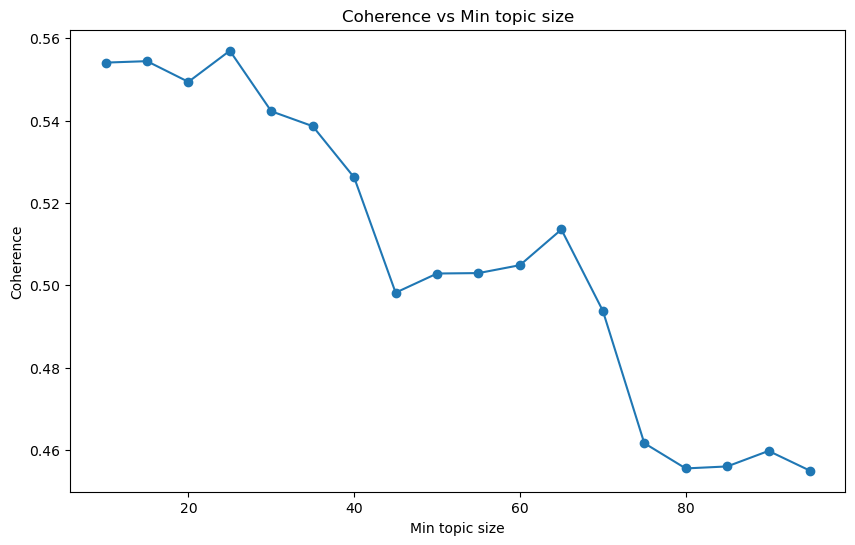

In [170]:
## Plot coherence score
# Define parameter range for min_cluster_size
min_cluster_sizes = range(10, 100, 5)
coherences = []
num_topics = []
min_clusters = []
uncategorized_topics = []

for min_cluster_size in min_cluster_sizes:
    # Get topic model
    topics, probs, topic_model = create_topic_model(documents, min_cluster_size, embeddings)

    # Get coherence and uncategorized topics
    coherence = calculate_coherence_score(topic_model, documents)
    uncategorized = topics.count(-1)

    # Append to list
    coherences.append(coherence)
    num_topics.append(len(set(topics)) - (1 if -1 in topics else 0))  # Number of topics
    min_clusters.append(min_cluster_size)
    uncategorized_topics.append(uncategorized)
    print(f"Min cluster size: {min_cluster_size}, Coherence: {coherence}, Number of uncategorized: {uncategorized}")

# save plot
plt.savefig('coherence_plot.png')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(min_clusters, coherences, marker='o')
plt.xlabel("Min topic size")
plt.ylabel("Coherence")
plt.title("Coherence vs Min topic size")
plt.show()

### Create optimal topic model and save

In [171]:
# choose topic size and run, this is the best model
topics, probs, topic_model = create_topic_model(documents, 15, embeddings)
topic_df = topic_model.get_topic_info()
topic_df

,Topic,Count,Name,Representation,Representative_Docs
0,-1,789,-1_ai_intelligence_artificial_study,"[ai, intelligence, artificial, study, data, re...",[The purpose of this paper is to study what as...
1,0,475,0_supply_chain_manufacturing_industry,"[supply, chain, manufacturing, industry, produ...",[The research aims to investigate the potentia...
2,1,227,1_ai_innovation_business_value,"[ai, innovation, business, value, adoption, or...",[The rise of AI technologies is generating nov...
3,2,217,2_hr_hrm_human_management,"[hr, hrm, human, management, ai, employee, rec...",[Given the swift progress of artificial intell...
4,3,198,3_financial_banking_banks_services,"[financial, banking, banks, services, intellig...","[In recent years, with the continuous developm..."
5,4,188,4_labor_employment_labour_automation,"[labor, employment, labour, automation, worker...",[As the largest industry that absorbs labor fr...
6,5,155,5_chatgpt_generative_language_education,"[chatgpt, generative, language, education, llm...","[Generative artificial intelligence (AI), such..."
7,6,150,6_healthcare_medical_health_patient,"[healthcare, medical, health, patient, ai, car...",[Artificial intelligence (AI) in healthcare is...
8,7,149,7_tourism_service_hospitality_robots,"[tourism, service, hospitality, robots, hotel,...",[The technological advances in artificial inte...
9,8,132,8_innovation_firms_gpt_ai,"[innovation, firms, gpt, ai, patents, patent, ...",[Using patent data for a panel sample of Europ...


###  Reduce outliers

Calculating initial topic assignments...
Found 789 outliers.
{-1: [('ai', 0.0252105983367018), ('intelligence', 0.015690850012732162), ('artificial', 0.015105965116439257), ('study', 0.015012024996402251), ('data', 0.01434261016611236), ('research', 0.014302921081370169), ('technology', 0.011496074863502513), ('digital', 0.011122191841318036), ('use', 0.010268861995394524), ('human', 0.009759499648425457)], 0: [('supply', 0.034259685518955606), ('chain', 0.030386553365755704), ('manufacturing', 0.019547187314105863), ('industry', 0.01917937844284321), ('production', 0.018138248354873508), ('40', 0.018050812981742596), ('technologies', 0.01792104348092469), ('data', 0.016491218741331255), ('management', 0.015397397574404559), ('artificial', 0.01422200919932945)], 1: [('ai', 0.03949099559374827), ('innovation', 0.029875779914553566), ('business', 0.028018694121436562), ('value', 0.023195938639647053), ('adoption', 0.021409633381828604), ('organizational', 0.01849857910452305), ('study', 

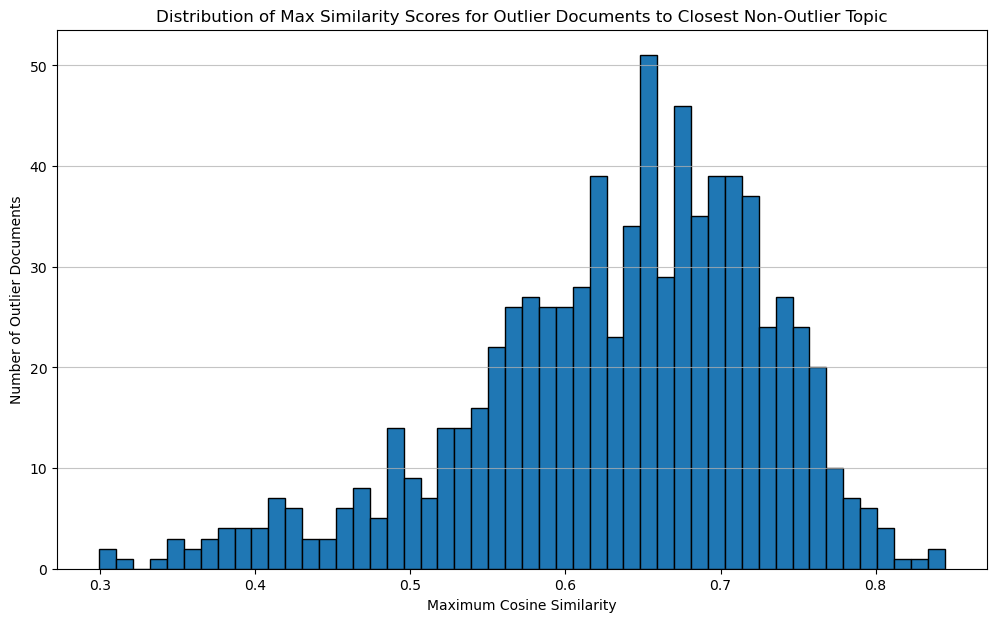


Descriptive Statistics for Maximum Similarities:
count    789.000000
mean       0.633558
std        0.096658
min        0.299555
25%        0.578222
50%        0.649437
75%        0.703732
90%        0.743493
95%        0.762881
99%        0.797129
max        0.844537
dtype: float64


In [172]:
print("Calculating initial topic assignments...")
# Get topics assigned before any outlier reduction attempts
initial_topics, _ = topic_model.transform(documents, embeddings=embeddings)

# 1. Identify outliers and their embeddings from the initial run
outlier_indices = np.where(np.array(initial_topics) == -1)[0]

if len(outlier_indices) > 0:
    print(f"Found {len(outlier_indices)} outliers.")
    outlier_embeddings = embeddings[outlier_indices]

    # 2. Get topic embeddings (corresponding to the initial topics)
    # Ensure topic_embeddings_ exists and is not empty
    if hasattr(topic_model, 'topic_embeddings_') and topic_model.topic_embeddings_ is not None and len(topic_model.topic_embeddings_) > 0:
        topic_embeddings = topic_model.topic_embeddings_
        
        # Filter out the outlier topic (-1) if it exists in topic_embeddings_
        topic_indices = [idx for idx in range(len(topic_embeddings)) 
                         if idx in topic_model.topic_representations_ and idx != -1]
        print(topic_model.topic_representations_)
        
        # Only use embeddings for actual topics (not the outlier topic)
        filtered_topic_embeddings = topic_embeddings[topic_indices]

        # 3. Calculate similarities between outliers and non-outlier topics
        print("Calculating similarities between outliers and non-outlier topics...")
        similarities = cosine_similarity(outlier_embeddings, filtered_topic_embeddings)

        # 4. Find maximum similarity for each outlier
        max_similarities = np.max(similarities, axis=1)

        # 5. Plot distribution
        print("Plotting similarity distribution...")
        plt.figure(figsize=(12, 7))
        plt.hist(max_similarities, bins=50, edgecolor='black')
        plt.title('Distribution of Max Similarity Scores for Outlier Documents to Closest Non-Outlier Topic')
        plt.xlabel('Maximum Cosine Similarity')
        plt.ylabel('Number of Outlier Documents')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

        # Print some descriptive statistics
        print("\nDescriptive Statistics for Maximum Similarities:")
        stats = pd.Series(max_similarities).describe(percentiles=[.25, .5, .75, .90, .95, .99])
        print(stats)

    else:
        print("Could not find valid topic embeddings in the model to compare against.")

else:
    print("No outliers found in the initial topic assignment.")

In [173]:
#  Choose threshold

for threshold in [0.6, 0.648466, 0.65, 0.67, 0.68, 0.69, 0.7]:
    print("Threshold: ", threshold)
    #  Reduce outliers
    new_topics = topic_model.reduce_outliers(documents, topics, embeddings = embeddings, strategy="embeddings", threshold=threshold)

    # update
    topic_model.update_topics(documents, topics=new_topics)

    # calc coherence
    coherence = calculate_coherence_score(topic_model, documents)
    print("Coherence score: ", coherence)

    # Count the number of documents per topic
    topic_counts = pd.Series(new_topics).value_counts().sort_index()

    # Display the counts
    print("Number of documents per topic:")
    print(topic_counts)

2025-04-22 12:04:14,335 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Threshold:  0.6


2025-04-22 12:04:26,883 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Coherence score:  0.38172500034542967
Number of documents per topic:
-1     258
 0     486
 1     339
 2     266
 3     209
 4     197
 5     160
 6     155
 7     166
 8     160
 9     124
 10    116
 11    105
 12     81
 13    124
 14    101
 15     96
 16     89
 17     56
 18     47
 19     41
 20     35
 21     48
 22     52
 23     35
 24     24
 25     22
Name: count, dtype: int64
Threshold:  0.648466


2025-04-22 12:04:39,240 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Coherence score:  0.381169065801526
Number of documents per topic:
-1     399
 0     480
 1     306
 2     259
 3     203
 4     192
 5     156
 6     154
 7     164
 8     148
 9     123
 10    115
 11    105
 12     80
 13    107
 14     95
 15     86
 16     85
 17     53
 18     47
 19     39
 20     34
 21     44
 22     43
 23     34
 24     21
 25     20
Name: count, dtype: int64
Threshold:  0.65


2025-04-22 12:04:51,754 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Coherence score:  0.381169065801526
Number of documents per topic:
-1     404
 0     480
 1     305
 2     259
 3     203
 4     192
 5     156
 6     154
 7     163
 8     148
 9     123
 10    114
 11    104
 12     80
 13    107
 14     95
 15     86
 16     84
 17     53
 18     47
 19     39
 20     34
 21     44
 22     43
 23     34
 24     21
 25     20
Name: count, dtype: int64
Threshold:  0.67


2025-04-22 12:05:04,130 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Coherence score:  0.38498126000654065
Number of documents per topic:
-1     476
 0     479
 1     292
 2     253
 3     202
 4     191
 5     156
 6     154
 7     163
 8     145
 9     123
 10    111
 11    103
 12     77
 13    102
 14     89
 15     80
 16     80
 17     49
 18     47
 19     37
 20     32
 21     43
 22     39
 23     28
 24     21
 25     20
Name: count, dtype: int64
Threshold:  0.68


2025-04-22 12:05:16,228 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Coherence score:  0.38780476374504846
Number of documents per topic:
-1     516
 0     479
 1     280
 2     249
 3     202
 4     191
 5     156
 6     154
 7     161
 8     143
 9     122
 10    110
 11    101
 12     77
 13    100
 14     88
 15     79
 16     77
 17     48
 18     47
 19     37
 20     31
 21     43
 22     36
 23     27
 24     19
 25     19
Name: count, dtype: int64
Threshold:  0.69


2025-04-22 12:05:28,515 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Coherence score:  0.3912191840434799
Number of documents per topic:
-1     548
 0     477
 1     273
 2     248
 3     201
 4     191
 5     156
 6     154
 7     160
 8     140
 9     122
 10    110
 11    101
 12     76
 13     95
 14     85
 15     76
 16     76
 17     48
 18     47
 19     37
 20     31
 21     40
 22     35
 23     27
 24     19
 25     19
Name: count, dtype: int64
Threshold:  0.7
Coherence score:  0.3968656241776415
Number of documents per topic:
-1     585
 0     477
 1     263
 2     244
 3     201
 4     191
 5     156
 6     152
 7     158
 8     137
 9     122
 10    109
 11     99
 12     76
 13     93
 14     81
 15     76
 16     73
 17     48
 18     47
 19     37
 20     31
 21     39
 22     34
 23     26
 24     19
 25     18
Name: count, dtype: int64


In [174]:
# choose topic size and run, this is the best model
topics, probs, topic_model = create_topic_model(documents, 15, embeddings)
new_topics = topic_model.reduce_outliers(documents, topics, embeddings = embeddings, strategy="embeddings", threshold=0.7)
topic_model.update_topics(documents, topics=new_topics, vectorizer_model=CountVectorizer(stop_words="english"))
topic_df = topic_model.get_topic_info()
topic_df.to_csv('topics_pub.csv')
topic_df

2025-04-22 12:05:52,240 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


,Topic,Count,Name,Representation,Representative_Docs
0,-1,585,-1_ai_data_intelligence_artificial,"[ai, data, intelligence, artificial, study, re...",[The purpose of this paper is to study what as...
1,0,477,0_supply_chain_manufacturing_industry,"[supply, chain, manufacturing, industry, produ...",[The research aims to investigate the potentia...
2,1,263,1_ai_innovation_business_value,"[ai, innovation, business, value, adoption, or...",[The rise of AI technologies is generating nov...
3,2,244,2_hr_hrm_human_ai,"[hr, hrm, human, ai, management, talent, emplo...",[Given the swift progress of artificial intell...
4,3,201,3_financial_banking_banks_services,"[financial, banking, banks, services, intellig...","[In recent years, with the continuous developm..."
5,4,191,4_labor_employment_labour_automation,"[labor, employment, labour, automation, worker...",[As the largest industry that absorbs labor fr...
6,5,156,5_chatgpt_generative_language_education,"[chatgpt, generative, language, education, llm...","[Generative artificial intelligence (AI), such..."
7,6,152,6_healthcare_medical_health_patient,"[healthcare, medical, health, patient, care, a...",[Artificial intelligence (AI) in healthcare is...
8,7,158,7_tourism_service_hospitality_robots,"[tourism, service, hospitality, robots, hotel,...",[The technological advances in artificial inte...
9,8,137,8_innovation_firms_ai_gpt,"[innovation, firms, ai, gpt, patents, patent, ...",[Using patent data for a panel sample of Europ...


In [175]:
# Check if necessary variables exist
required_vars = ['topics', 'new_topics', 'documents', 'topic_model', 'embeddings']
missing_vars = [var for var in required_vars if var not in locals() and var not in globals()]

if missing_vars:
    print(f"Error: One or more required variables not found: {missing_vars}")
    print("Please ensure the cell that defines the final model (e.g., execution_count 254) and earlier cells defining 'documents' and 'embeddings' have been run.")
else:
    print("Required variables found. Proceeding...")

    # Convert topics to numpy arrays for efficient comparison
    initial_topics_array = np.array(topics) # Using 'topics' from the final cell as initial
    final_topics_array = np.array(new_topics) # Using 'new_topics' from the final cell as final

    # 1. Find indices of initial outliers (using 'topics')
    initial_outlier_indices = np.where(initial_topics_array == -1)[0]

    # 2. Find indices of final non-outliers (using 'new_topics')
    final_non_outlier_indices = np.where(final_topics_array != -1)[0]

    # 3. Find indices of documents that *changed* from outlier to non-outlier
    changed_indices = np.array(list(set(initial_outlier_indices) & set(final_non_outlier_indices)))

    print(f"\nFound {len(changed_indices)} documents that were reassigned from outliers when applying the final threshold (0.7).")

    reassigned_data = [] # List to store data for CSV

    if len(changed_indices) > 0:
        print(f"Processing {len(changed_indices)} reassigned documents for CSV output...")

        # Ensure documents is indexable
        if not isinstance(documents, (list, np.ndarray, pd.Series)):
            print("Warning: 'documents' might not be in an easily indexable format. Trying to convert to list.")
            try:
                 documents_list = list(documents)
            except TypeError:
                 print("Error: Could not convert 'documents' to a list. Cannot include document text.")
                 documents_list = None
        else:
             documents_list = documents # Use as is if already suitable

        if documents_list is not None:
            for idx in changed_indices: # Process all changed indices
                original_topic = initial_topics_array[idx] # Should be -1
                new_topic = final_topics_array[idx]
                document_text_str = "[Error retrieving document text]" # Default
                topic_words_str = "[Error retrieving topic words]" # Default

                try:
                    # Handle potential conversion if documents is pandas Series vs list/array
                    if isinstance(documents_list, pd.Series):
                        try:
                            document_text_str = str(documents_list.iloc[idx])
                        except IndexError:
                             try:
                                  document_text_str = str(documents_list[idx])
                             except KeyError: pass # Keep default error message
                    else:
                         try:
                            document_text_str = str(documents_list[idx])
                         except IndexError: pass # Keep default error message
                except Exception as e:
                    document_text_str = f"[Error retrieving document text: {e}]"

                try:
                    # Use the FINAL topic_model instance to get words for the NEW topic
                    topic_words = topic_model.get_topic(new_topic)
                    if topic_words: # Check if topic_words is not False or None
                         topic_words_str = ", ".join([f"{word}({score:.3f})" for word, score in topic_words])
                    else:
                         topic_words_str = f"(Topic {new_topic} merged/removed/no words)"
                except ValueError as ve:
                     topic_words_str = f"(Topic {new_topic} invalid: {ve})"
                except Exception as e:
                    topic_words_str = f"(Error retrieving words: {e})"

                reassigned_data.append({
                    'Document Index': idx,
                    'Original Topic': original_topic,
                    'New Topic': new_topic,
                    'New Topic Keywords': topic_words_str,
                    'Document Text': document_text_str
                })
        else:
             print("Cannot process document details because 'documents' could not be processed.")

        # Create DataFrame and save to CSV
        if reassigned_data:
            reassigned_df = pd.DataFrame(reassigned_data)
            csv_filename = 'reassigned_outliers.csv'
            try:
                reassigned_df.to_csv(csv_filename, index=False)
                print(f"\nSuccessfully saved details of {len(reassigned_data)} reassigned documents to '{csv_filename}'")
            except Exception as e:
                print(f"\nError saving data to CSV '{csv_filename}': {e}")
        else:
            print("\nNo data collected to save to CSV.")


    elif len(initial_outlier_indices) > 0:
        print("\nNo documents were reassigned from outliers based on the final threshold application.")
        print(f"(There were {len(initial_outlier_indices)} outliers in the 'topics' variable before the final reduction).")
    else:
         print("\nThere were no initial outliers in the 'topics' variable to reassign.")

Required variables found. Proceeding...

Found 204 documents that were reassigned from outliers when applying the final threshold (0.7).
Processing 204 reassigned documents for CSV output...

Successfully saved details of 204 reassigned documents to 'reassigned_outliers.csv'


In [176]:
# Save the model
with open('pub_paper_model.pkl', 'wb') as f:
    pickle.dump(topic_model, f)

print("Model saved successfully!")

Model saved successfully!


## Label topics and display paper and citation counts

### Label topics

In [177]:
# load model
with open('pub_paper_model.pkl', 'rb') as f:
    topic_model = pickle.load(f)

# Load topics from the model
topics = topic_model.topics_
probs = topic_model.probabilities_

print(f"Loaded {len(topics)} topics and their probabilities from the model")

Loaded 3592 topics and their probabilities from the model


In [270]:
custom_topic_labels = {
    -1: "",
    0: "Supply Chains & Manufacturing",
    1: "Business Strategy & Innovation",
    2: "Human Resources",
    3: "Finance & Banking",
    4: "Automation & Labour",
    5: "Generative AI",
    6: "Healthcare & Medicine",
    7: "Tourism and Hospitality",
    8: "Innovation and Patents",
    9: "Climate & Energy Solutions",
    10: "Customer Service Chatbots",
    11: "Accounting & Auditing",
    12: "Sustainability & ESG",
    13: "Governance, Risk & Ethics",
    14: "Consumer Behaviour & Online Shopping",
    15: "Workplace Adoption & Perceptions",
    16: "Marketing",
    17: "Corporate Strategy & Transparency",
    18: "Construction",
    19: "Algorithmic Pricing",
    20: "Agriculture & Food Systems",
    21: "Decision-making",
    22: "Explainability & Trust",
    23: "Sustainability Goals",
    24: "Public Services",
    25: "Fairness and Bias",
}

topic_model.set_topic_labels(custom_topic_labels)

In [271]:
papers_topics = pd.DataFrame({'abstract': documents, 'Topic': topics, 'Probability': probs})
papers_topics = papers_topics.merge(data, on = "abstract", how = "inner")
papers_topics = papers_topics.rename(columns = {"abstract" : "abstract"})
papers_topics.to_csv('papers_topics_pub.csv')
papers_topics

,abstract,Topic,Probability,DOI,Cited by,Publication Year,title,author,Abstract_Short,Abstract_Short_last
0,"For employees, work involves taking breaks as ...",-1,0.000000,10.4018/JOEUC.329596,1,2023,The Shape of Workbreaks to Come: Reframing Cyb...,Oravec J.A.,"For employees, work involves taking breaks as ...",identified inclinations can be used to engage ...
1,The term 'artificial intelligence' (AI) refers...,1,0.000000,10.1109/ICONSTEM60960.2024.10568724,0,2024,A Novel Approach of Data-Driven Strategic Deci...,Umamaheswari S.; Valarmathi A.; Dhinakaran D.P...,The term 'artificial intelligence' (AI) refers...,man-made intelligence new businesses. The exam...
2,This study aims to explore how firms' innovati...,8,0.820295,10.1504/IJTM.2020.112122,5,2020,How to become the chosen one in the artificial...,Li J.; Liu Z.; Zhou J.,This study aims to explore how firms' innovati...,"is, the relationship between innovation perfor..."
3,This research aims to investigate the acceptan...,14,0.000000,10.4018/IJEBR.323796,0,2023,A Study of Customer Acceptance of Artificial I...,Choi Y.,This research aims to investigate the acceptan...,and the customer’s ability to use AI devices i...
4,Generative AI appears poised to transform whit...,5,0.792033,10.1145/3630106.3658987,0,2024,The Impact and Opportunities of Generative AI ...,Wolfe R.; Mitra T.,Generative AI appears poised to transform whit...,"Throughout, we highlight the importance of hum..."
...,...,...,...,...,...,...,...,...,...,...
3587,"Since the introduction of ChatGPT, the leading...",5,0.773871,10.1016/j.jbusres.2024.114720,2,2024,Artificial intelligence and consumer behavior:...,Hermann E.; Puntoni S.,"Since the introduction of ChatGPT, the leading...","field of GenAI. Here, we differentiate between..."
3588,IBM has deployed its Predictive Analytics for ...,0,0.904406,10.1287/INTE.2020.1064,1,2021,IBM predictive analytics reduces server downtime,Bogojeska J.; Giurgiu I.; Stark G.; Wiesmann D.,IBM has deployed its Predictive Analytics for ...,We demonstrate the model's effectiveness by co...
3589,Natural resources have long been considered a ...,9,0.656835,10.1016/j.resourpol.2024.104831,0,2024,Nonlinear relationship between natural resourc...,Xie T.; Xu Y.; Li Y.,Natural resources have long been considered a ...,value of strategic investments in emerging tec...
3590,Purpose: This study aims to explore the role t...,14,0.697690,10.1108/IJRDM-12-2022-0493,7,2023,The role of artificial intelligence in improvi...,Calvo A.V.; Franco A.D.; Frasquet M.,Purpose: This study aims to explore the role t...,This study presents insights on the impact of ...


### Citations

In [272]:
topics_citations_sum = papers_topics[['Cited by', 'Topic']].groupby('Topic').sum().reset_index().rename(columns = {'Cited by':'sum_citations'})
topics_citations_average = papers_topics[['Cited by', 'Topic']].groupby('Topic').mean().reset_index().rename(columns = {'Cited by':'mean_citations'})
topics_citations_median = papers_topics[['Cited by', 'Topic']].groupby('Topic').median().reset_index().rename(columns = {'Cited by':'med_citations'})
topics_citations_max = papers_topics[['Cited by', 'Topic']].groupby('Topic').max().reset_index().rename(columns = {'Cited by':'max_citations'})

topics_citations = pd.merge(topics_citations_sum, topics_citations_average, on = 'Topic', how = 'inner')
topics_citations = pd.merge(topics_citations, topics_citations_median, on = 'Topic', how = 'inner')
topics_citations = pd.merge(topics_citations, topics_citations_max, on = 'Topic', how = 'inner')

topics_citations.sort_values('med_citations', ascending=False)

,Topic,sum_citations,mean_citations,med_citations,max_citations
11,10,3551,32.577982,12.0,530
25,24,264,13.894737,10.0,79
22,21,1507,38.641026,9.0,286
8,7,6093,38.563291,9.0,550
9,8,2187,15.963504,6.0,225
24,23,1577,60.653846,5.5,474
15,14,1579,19.493827,5.0,405
4,3,3466,17.243781,5.0,344
23,22,1181,34.735294,5.0,368
20,19,637,17.216216,5.0,132


## Extract research questions

In [273]:
# ## WRITE PROMPT

# prompt = "You are an academic expert in economics, finance, management and innovation studies. You are provided with abstracts from academic papers. Your goal is to carefully review each abstract to identify the main research question. Then, summarize this research question in less than 50 words."

# example1 = """The environmental effect of operating activities in the manufacturing industry is crucial to the sustainable development of the economy and society. Since we have entered the era of information explosion, the artificial intelligence has been involved to address the environmental problems caused by daily operations. This study examines the complex relation between artificial intelligence application and corporate environmental investment. The results show that: (1) AI application have a direct and positive impact on corporate environmental investment; (2) Managerial myopia plays a negative moderating role, inhibiting the positive effect of AI application on corporate environmental investment; (3) Companies' pollution emission mediates the relationship between AI application and corporate environmental investment. When reduced by AI application, a lower pollution emission will trigger a larger scale of corporate environmental investment; (4) Compared with under-valued companies and those in the Western region, AI application has a greater positive impact on the environmental investment of the over-valued companies and those in the East-Central region. By verifying the relationship between artificial intelligence applications and manufacturing enterprise investment, this study has a positive impact on promoting green innovation in the manufacturing industry and is of great significance for sustainable development strategies."""
# output1 = "What is the relationship between artificial intelligence application and corporate environmental investment?"

# example2 = "This paper explores the intersection between artificial intelligence and nuclear energy, shedding light on the intriguing scenario when these two sectors jointly consturct. Through the application of both full-sample and sub-sample methodologies, this study identifies the time-dependent interrelationships between China's artificial intelligence index (AI) and nuclear energy indicator (NUC). The quantitative analysis presents that AI's influence on nuclear energy is twofold. On one hand, AI contributes positively by acting as a catalyst and enhancing safety measures in the nuclear sector. On the other, the impact might be perceived negatively, primarily when cost-effective alternative energy sources overshadow the benefits of nuclear energy. Additionally, the positive effect of NUC on AI highlights the benefits derived from nuclear's expansive and consistent energy output, catering efficiently to AI's substantial energy demands. In essence, AI and NUC are found to be complementary, with each having the potential to propel the other forward. This reciprocity paves the way for a synergistic relationship, promising mutual benefits. The study introduces a fresh perspective on the co-evolution of energy and technology, offering thought-provoking recommendations aimed at cultivating the collaborative growth of AI and NUC towards a common good. Â© 2023"
# output2 = "What is the relationship between artificial intelligence and nuclear energy, and how do they influence each other's development?"

# example3 = "Fairness is a crucial concept in the context of artificial intelligence ethics and policy. It is an incremental component in existing ethical principle frameworks, especially for algorithm-enabled decision systems. Yet, translating fairness principles into context specific practices can be undermined by multiple unintended organisational risks. This paper argues that there is a gap between the potential and actual realized value of AI. Therefore, this research attempts to answer how organisations can mitigate AI risks that relate to unfair decision outcomes. We take a holistic view by analyzing the challenges throughout a typical AI product life cycle while focusing on the critical question of how rather broadly defined fairness principles may be translated into day-to-day practical solutions at the organizational level. We report on an exploratory case study of a social impact microfinance organization that is using AI-enabled credit scoring to support the screening process to particularly financially marginalized entrepreneurs. This paper highlights the importance of considering the strategic role of the organisation when developing and evaluating fair algorithm- enabled decision systems. The proposed framework and results of this study can be used to inspire the right questions that suit the context an organisation is situated in when implementing fair AI. Â© 2023, The Author(s), under exclusive license to Springer Nature Switzerland AG."
# output3 = "How can organizations translate broad fairness principles into practical solutions to mitigate AI-related risks in decision-making systems?"

# example4 = "The behavior of artificial intelligence (AI) algorithms is shaped by how they learn about their environment. We compare the prices generated by AIs that use different learning protocols when there is market interaction. Asynchronous learning occurs when the AI only learns about the return from the action it took. Synchronous learning occurs when the AI conducts counterfactuals to learn about the returns it would have earned had it taken an alternative action. The two lead to markedly different market prices. When future profits are not given positive weight by the AI, (perfect) synchronous updating leads to competitive pricing, while asynchronous can lead to pricing close to monopoly levels. We investigate how this result varies when either counterfactuals can only be calculated imperfectly and/or when the AI places a weight on future profits. Lastly, we investigate performance differences between offline and online play. Â© 2023 Wiley Periodicals LLC."
# output4 = "How do different AI learning protocols affect market pricing behavior, and what factors influence their competitive or monopolistic outcomes?"

In [274]:
# ## PROMPT GPT-4o mini

# from openai import OpenAI
# import time
# import logging
# from tqdm import tqdm
# import re
# from google.colab import userdata

# # set up logging
# logging.basicConfig(level = logging.INFO)

# # set up api
# api_key = userdata.get("OPENAI_API_KEY")
# client = OpenAI(api_key = api_key)

# # set up data dict
# data_dict = {
#         'abstract': [],
#         'Question': []
#     }

# # loop through abstracts
# for index, row in tqdm(papers_topics.iterrows(), desc = 'Processing abstracts'):
#     response = client.chat.completions.create(
#         model="gpt-4o-mini",
#         max_tokens=200,
#         temperature=0,
#         seed=2345,
#         messages=[
#             {"role": "system", "content": prompt},
#             {"role": "user", "content": example1},
#             {"role": "assistant", "content": output1},
#             {"role": "user", "content": example2},
#             {"role": "assistant", "content": output2},
#             {"role": "user", "content": example3},
#             {"role": "assistant", "content": output3},
#             {"role": "user", "content": example4},
#             {"role": "assistant", "content": output4},
#             {"role": "user", "content": row['abstract']}
#         ]
#     )

#     # store data in df
#     data_dict['abstract'].append(row['abstract'])
#     message = response.choices[0].message.content
#     data_dict['Question'].append(message)

# # Display the DataFrame
# questions = pd.DataFrame(data_dict)
# questions.to_csv('questions_pub.csv')
# questions

In [275]:
questions = pd.read_csv('questions_pub.csv', index_col = 0)
papers_topics = papers_topics.merge(questions, on = "abstract", how = "left")

In [276]:
papers_topics

,abstract,Topic,Probability,DOI,Cited by,Publication Year,title,author,Abstract_Short,Abstract_Short_last,Question
0,"For employees, work involves taking breaks as ...",-1,0.000000,10.4018/JOEUC.329596,1,2023,The Shape of Workbreaks to Come: Reframing Cyb...,Oravec J.A.,"For employees, work involves taking breaks as ...",identified inclinations can be used to engage ...,"How are AI methodologies and ""bossware"" platfo..."
1,The term 'artificial intelligence' (AI) refers...,1,0.000000,10.1109/ICONSTEM60960.2024.10568724,0,2024,A Novel Approach of Data-Driven Strategic Deci...,Umamaheswari S.; Valarmathi A.; Dhinakaran D.P...,The term 'artificial intelligence' (AI) refers...,man-made intelligence new businesses. The exam...,What are the challenges and impacts of impleme...
2,This study aims to explore how firms' innovati...,8,0.820295,10.1504/IJTM.2020.112122,5,2020,How to become the chosen one in the artificial...,Li J.; Liu Z.; Zhou J.,This study aims to explore how firms' innovati...,"is, the relationship between innovation perfor...",How does a firm's innovation performance influ...
3,This research aims to investigate the acceptan...,14,0.000000,10.4018/IJEBR.323796,0,2023,A Study of Customer Acceptance of Artificial I...,Choi Y.,This research aims to investigate the acceptan...,and the customer’s ability to use AI devices i...,What factors influence customer acceptance of ...
4,Generative AI appears poised to transform whit...,5,0.792033,10.1145/3630106.3658987,0,2024,The Impact and Opportunities of Generative AI ...,Wolfe R.; Mitra T.,Generative AI appears poised to transform whit...,"Throughout, we highlight the importance of hum...",How does generative AI impact fact-checking or...
...,...,...,...,...,...,...,...,...,...,...,...
3587,"Since the introduction of ChatGPT, the leading...",5,0.773871,10.1016/j.jbusres.2024.114720,2,2024,Artificial intelligence and consumer behavior:...,Hermann E.; Puntoni S.,"Since the introduction of ChatGPT, the leading...","field of GenAI. Here, we differentiate between...",What is the impact of Generative Artificial In...
3588,IBM has deployed its Predictive Analytics for ...,0,0.904406,10.1287/INTE.2020.1064,1,2021,IBM predictive analytics reduces server downtime,Bogojeska J.; Giurgiu I.; Stark G.; Wiesmann D.,IBM has deployed its Predictive Analytics for ...,We demonstrate the model's effectiveness by co...,What are the results and effectiveness of IBM'...
3589,Natural resources have long been considered a ...,9,0.656835,10.1016/j.resourpol.2024.104831,0,2024,Nonlinear relationship between natural resourc...,Xie T.; Xu Y.; Li Y.,Natural resources have long been considered a ...,value of strategic investments in emerging tec...,What is the nonlinear relationship between nat...
3590,Purpose: This study aims to explore the role t...,14,0.697690,10.1108/IJRDM-12-2022-0493,7,2023,The role of artificial intelligence in improvi...,Calvo A.V.; Franco A.D.; Frasquet M.,Purpose: This study aims to explore the role t...,This study presents insights on the impact of ...,What role do artificial intelligence systems p...


## Subtopic modeling

In [277]:
for topic in range(0, len(topic_df)):
  papers = papers_topics[papers_topics['Topic'] == topic][['abstract', 'Cited by', 'Publication Year', 'DOI', 'title', 'author', 'Question']]
  subdocuments = papers['abstract']
  subdocuments = subdocuments.reset_index(drop=True)
  subdocuments = subdocuments.tolist()
  if len(subdocuments) > 30:
    gc.collect()
    # Extract the embeddings for just the documents in this topic
    topic_indices = papers_topics[papers_topics['Topic'] == topic].index.tolist()
    topic_embeddings = embeddings[topic_indices]
    
    subtopics, subprobs, sub_topic_model = create_topic_model(subdocuments, 10, topic_embeddings)
    mini_df = pd.DataFrame({'abstract': subdocuments, 'Topic': subtopics})
    mini_df = mini_df.merge(papers, on = 'abstract', how = 'left')
    mini_df.to_csv(f'subtopics/subtopics_{topic}_papers.csv')
    mini_topic_df = sub_topic_model.get_topic_info()
    print(mini_topic_df)
    mini_topic_df.to_csv(f'subtopics/subtopics_{topic}.csv')

   Topic  Count                                     Name  \
0     -1     45     -1_ai_industry_process_manufacturing   
1      0    167   0_industry_production_manufacturing_40   
2      1    152                  1_supply_chain_ai_study   
3      2     71  2_logistics_technologies_digital_supply   
4      3     27       3_ce_circular_economy_technologies   
5      4     15          4_green_supply_gscm_sustainable   

                                      Representation  \
0  [ai, industry, process, manufacturing, artific...   
1  [industry, production, manufacturing, 40, data...   
2  [supply, chain, ai, study, research, resilienc...   
3  [logistics, technologies, digital, supply, cha...   
4  [ce, circular, economy, technologies, ai, stud...   
5  [green, supply, gscm, sustainable, chain, stud...   

                                 Representative_Docs  
0  [Considering the novel concept of Industry 5.0...  
1  [Employing recent research results covering In...  
2  [The study aims to

In [278]:
def combine_subtopic_papers(base_path):
    # Define the pattern to match all subtopic paper files
    pattern = os.path.join(base_path, "subtopics_*_papers.csv")

    # Get all matching files
    file_paths = glob.glob(pattern)

    # Create an empty list to store individual dataframes
    all_dfs = []

    # Process each file
    for file_path in file_paths:
        # Extract the main topic number from the filename
        filename = os.path.basename(file_path)
        main_topic = int(filename.split('_')[1])

        # Read the CSV
        df = pd.read_csv(file_path, index_col=0)

        # read topic df description
        topic_df = pd.read_csv(f'subtopics/subtopics_{main_topic}.csv', index_col = 0)
        topic_df = topic_df[['Topic', 'Name']]
        topic_df = topic_df.rename(columns = {'Name': 'subtopic name'})

        # merge with labels
        df = df.merge(topic_df, on = 'Topic', how = 'left')

        # Add a column for the main topic
        df['broad_topic'] = main_topic

        # Append to our list
        all_dfs.append(df)

    # Concatenate all dataframes
    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)
        return combined_df
    else:
        print("No files found matching the pattern.")
        return None

# Usage
base_directory = 'subtopics/'
papers_subtopics = combine_subtopic_papers(base_directory)

# Save the combined dataframe
if papers_subtopics is not None:
    output_path = os.path.join(base_directory, 'papers_subtopics.csv')
    papers_subtopics = papers_subtopics.rename(columns = {'Topic': 'subtopic'})
    papers_subtopics = papers_subtopics[['abstract', 'subtopic', 'subtopic name']]
    papers_subtopics.to_csv(output_path)
    print(f"Combined dataframe saved to {output_path}")
    print(f"Shape of combined dataframe: {papers_subtopics.shape}")

Combined dataframe saved to subtopics/papers_subtopics.csv
Shape of combined dataframe: (2944, 3)


In [279]:
papers_subtopics

,abstract,subtopic,subtopic name
0,Artificial intelligence (AI) is a tool that fi...,0,0_financial_ai_intelligence_artificial
1,Purpose: This study aims to understand the imp...,2,2_banking_mobile_perceived_study
2,Purpose: The purpose of this paper is to provi...,-1,-1_financial_intelligence_artificial_data
3,Complementing Europe's bank-based system with ...,0,0_financial_ai_intelligence_artificial
4,Artificial intelligence (AI) is receiving incr...,1,1_ai_banking_banks_customer
...,...,...,...
2939,Purpose: This study aims to investigate whethe...,-1,-1_employees_stara_awareness_service
2940,Artificial intelligence (AI) plays a crucial r...,0,0_ai_employees_job_employee
2941,The hotel industry’s artificial intelligence (...,1,1_ai_turnover_employees_study
2942,This study examines how employees’ perceived A...,1,1_ai_turnover_employees_study


In [280]:
papers_topics_full = papers_topics.merge(papers_subtopics, on = ['abstract'], how = 'left')
papers_topics_full = papers_topics_full.drop(columns = ['Abstract_Short'])
papers_topics_full.to_csv('papers_topics_full.csv')
papers_topics_full

,abstract,Topic,Probability,DOI,Cited by,Publication Year,title,author,Abstract_Short_last,Question,subtopic,subtopic name
0,"For employees, work involves taking breaks as ...",-1,0.000000,10.4018/JOEUC.329596,1,2023,The Shape of Workbreaks to Come: Reframing Cyb...,Oravec J.A.,identified inclinations can be used to engage ...,"How are AI methodologies and ""bossware"" platfo...",NaN,NaN
1,The term 'artificial intelligence' (AI) refers...,1,0.000000,10.1109/ICONSTEM60960.2024.10568724,0,2024,A Novel Approach of Data-Driven Strategic Deci...,Umamaheswari S.; Valarmathi A.; Dhinakaran D.P...,man-made intelligence new businesses. The exam...,What are the challenges and impacts of impleme...,3.0,3_ai_intelligence_business_artificial
2,This study aims to explore how firms' innovati...,8,0.820295,10.1504/IJTM.2020.112122,5,2020,How to become the chosen one in the artificial...,Li J.; Liu Z.; Zhou J.,"is, the relationship between innovation perfor...",How does a firm's innovation performance influ...,-1.0,-1_firms_technology_ai_patent
3,This research aims to investigate the acceptan...,14,0.000000,10.4018/IJEBR.323796,0,2023,A Study of Customer Acceptance of Artificial I...,Choi Y.,and the customer’s ability to use AI devices i...,What factors influence customer acceptance of ...,-1.0,-1_ai_study_consumers_research
4,Generative AI appears poised to transform whit...,5,0.792033,10.1145/3630106.3658987,0,2024,The Impact and Opportunities of Generative AI ...,Wolfe R.; Mitra T.,"Throughout, we highlight the importance of hum...",How does generative AI impact fact-checking or...,0.0,0_chatgpt_ai_generative_models
...,...,...,...,...,...,...,...,...,...,...,...,...
3587,"Since the introduction of ChatGPT, the leading...",5,0.773871,10.1016/j.jbusres.2024.114720,2,2024,Artificial intelligence and consumer behavior:...,Hermann E.; Puntoni S.,"field of GenAI. Here, we differentiate between...",What is the impact of Generative Artificial In...,0.0,0_chatgpt_ai_generative_models
3588,IBM has deployed its Predictive Analytics for ...,0,0.904406,10.1287/INTE.2020.1064,1,2021,IBM predictive analytics reduces server downtime,Bogojeska J.; Giurgiu I.; Stark G.; Wiesmann D.,We demonstrate the model's effectiveness by co...,What are the results and effectiveness of IBM'...,1.0,1_supply_chain_ai_study
3589,Natural resources have long been considered a ...,9,0.656835,10.1016/j.resourpol.2024.104831,0,2024,Nonlinear relationship between natural resourc...,Xie T.; Xu Y.; Li Y.,value of strategic investments in emerging tec...,What is the nonlinear relationship between nat...,3.0,3_resource_natural_mining_economic
3590,Purpose: This study aims to explore the role t...,14,0.697690,10.1108/IJRDM-12-2022-0493,7,2023,The role of artificial intelligence in improvi...,Calvo A.V.; Franco A.D.; Frasquet M.,This study presents insights on the impact of ...,What role do artificial intelligence systems p...,-1.0,-1_ai_study_consumers_research


## Visualisations

In [281]:
# Add labels

topic_df['Label'] = topic_df['Topic'].apply(lambda x: custom_topic_labels[x])
topic_df.to_csv('topics_pub.csv')
topic_df

,Topic,Count,Name,Representation,Representative_Docs,Label
0,-1,585,-1_ai_data_intelligence_artificial,"[ai, data, intelligence, artificial, study, re...",[The purpose of this paper is to study what as...,
1,0,477,0_supply_chain_manufacturing_industry,"[supply, chain, manufacturing, industry, produ...",[The research aims to investigate the potentia...,Supply Chains & Manufacturing
2,1,263,1_ai_innovation_business_value,"[ai, innovation, business, value, adoption, or...",[The rise of AI technologies is generating nov...,Business Strategy & Innovation
3,2,244,2_hr_hrm_human_ai,"[hr, hrm, human, ai, management, talent, emplo...",[Given the swift progress of artificial intell...,Human Resources
4,3,201,3_financial_banking_banks_services,"[financial, banking, banks, services, intellig...","[In recent years, with the continuous developm...",Finance & Banking
5,4,191,4_labor_employment_labour_automation,"[labor, employment, labour, automation, worker...",[As the largest industry that absorbs labor fr...,Automation & Labour
6,5,156,5_chatgpt_generative_language_education,"[chatgpt, generative, language, education, llm...","[Generative artificial intelligence (AI), such...",Generative AI
7,6,152,6_healthcare_medical_health_patient,"[healthcare, medical, health, patient, care, a...",[Artificial intelligence (AI) in healthcare is...,Healthcare & Medicine
8,7,158,7_tourism_service_hospitality_robots,"[tourism, service, hospitality, robots, hotel,...",[The technological advances in artificial inte...,Tourism and Hospitality
9,8,137,8_innovation_firms_ai_gpt,"[innovation, firms, ai, gpt, patents, patent, ...",[Using patent data for a panel sample of Europ...,Innovation and Patents


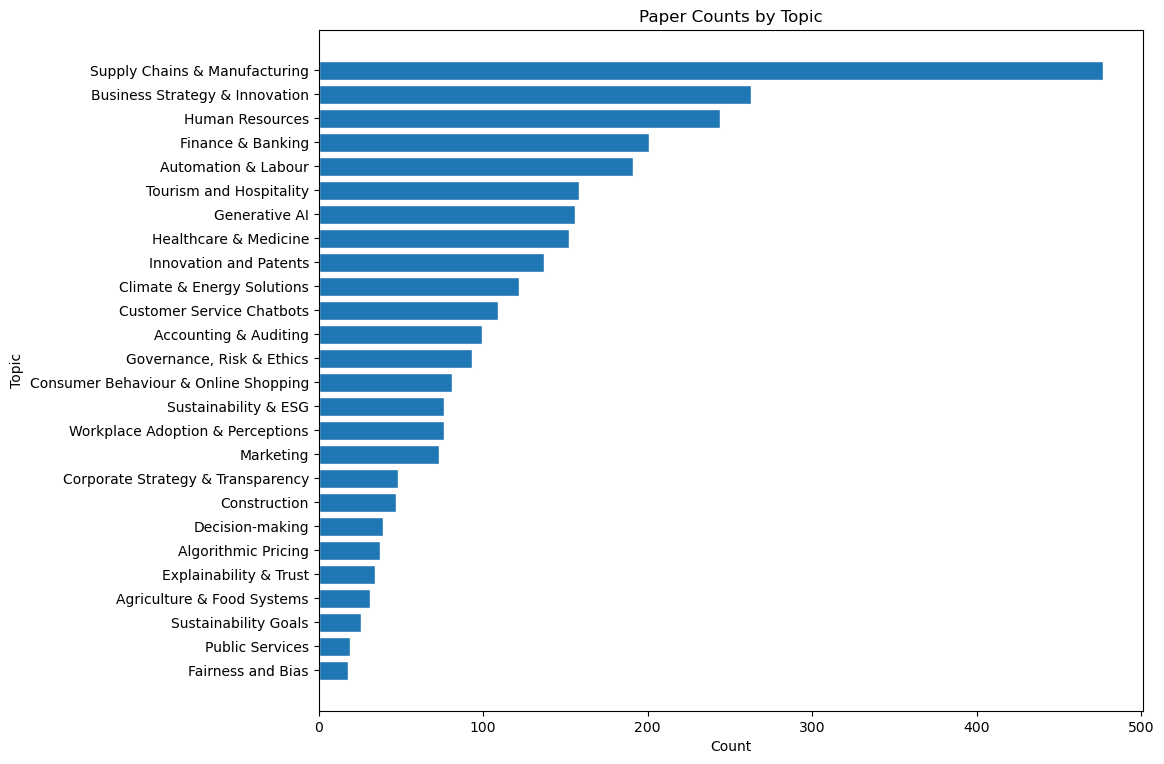

In [282]:
# Paper counts by topic

# Filter out the '-1' topic
proper_topics = topic_df[topic_df['Topic'] != -1]

# Sort by count (topic size)
proper_topics = proper_topics.sort_values('Count', ascending=True)

# Creating the bar chart
plt.figure(figsize=(12, 8))
plt.barh(proper_topics['Label'], proper_topics['Count'], edgecolor="white")
plt.xlabel("Count")
plt.ylabel("Topic")
plt.title("Paper Counts by Topic")
plt.tight_layout(pad=2)

# Saving the figure to a file
file_path = "images/pub_counts.pdf"
plt.savefig(file_path, format="pdf", bbox_inches="tight")
plt.show()

In [283]:
fig = topic_model.visualize_barchart(topics = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], custom_labels = True)
fig.show()
fig.write_image("images/pub_bars.pdf")

In [284]:
## Hierarchy

from scipy.cluster import hierarchy as sch

# Hierarchical topics
# linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
hierarchical_topics = topic_model.hierarchical_topics(documents)

topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 25/25 [00:00<00:00, 770.58it/s]


In [285]:
fig = topic_model.visualize_topics(custom_labels = True)
fig.show()
fig.write_image("images/pub_intertopic_distances.pdf")

In [286]:
fig = topic_model.visualize_heatmap(topics = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], custom_labels = True, width = 800, height = 600)
fig.show()
fig.write_image("images/pub_similarity_matrix.pdf")

In [287]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Define your list of target words
target_words = ['adoption', 'innovation', 'work', 'business', 'ethical', 'responsible', 'regulation', 'chatgpt'] # Add/remove words as needed

scores_per_topic_list = []

try:
    # Check if custom_topic_labels is defined
    if 'custom_topic_labels' not in locals() or not isinstance(custom_topic_labels, dict):
        raise NameError("Please define the 'custom_topic_labels' dictionary in the cell above.")

    c_tf_idf_matrix = topic_model.c_tf_idf_
    vocab_list = list(topic_model.vectorizer_model.get_feature_names_out())
    vocab_dict = {word: i for i, word in enumerate(vocab_list)}

    word_indices = {}
    found_words = []
    not_found_words = []
    for word in target_words:
        idx = vocab_dict.get(word)
        if idx is not None:
            word_indices[word] = idx
            found_words.append(word)
        else:
            not_found_words.append(word)

    if not_found_words:
        print(f"Warning: Words not found in vocabulary and will be skipped: {not_found_words}")

    if not found_words:
        print("Error: None of the target words were found in the vocabulary.")
    else:
        all_topic_ids = sorted(list(topic_model.get_topic_freq().Topic.unique()))
        if -1 in all_topic_ids:
            all_topic_ids.remove(-1)

        index_offset = 1 if -1 in topic_model.get_topic_freq().Topic.unique() else 0

        # Use custom_topic_labels for Topic Name
        for topic_id in all_topic_ids:
            topic_index = topic_id + index_offset

            if 0 <= topic_index < c_tf_idf_matrix.shape[0]:
                # *** Use custom label, fallback if topic_id not in dict ***
                topic_name = custom_topic_labels.get(topic_id, f"Topic {topic_id} (Custom label missing)")
                topic_data = {"Topic ID": topic_id, "Topic Name": topic_name}

                for word in found_words:
                    word_index = word_indices[word]
                    score = c_tf_idf_matrix[topic_index, word_index]
                    topic_data[word] = score

                scores_per_topic_list.append(topic_data)
            else:
                print(f"Warning: Topic index {topic_index} (for Topic ID {topic_id}) is out of bounds.")

        scores_df = pd.DataFrame(scores_per_topic_list)

        print(f"c-TF-IDF Scores for words {found_words} across all topics:")

        # --- Styling the DataFrame ---
        styled_df_to_render = None
        table_html = "" # Initialize table_html
        try:
            if not scores_df.empty:
                # *** Use 'Topic Name' (which now contains custom labels) as index ***
                df_to_style = scores_df.set_index('Topic Name')
                df_to_style = df_to_style[found_words]
                cmap = plt.get_cmap('Blues')
                format_dict = {word: "{:.4f}" for word in found_words}

                # Apply styling (gradient, format). Font is handled via CSS wrapper.
                styled_result = df_to_style.style.background_gradient(cmap=cmap, axis=0, subset=found_words) \
                                             .format(format_dict) \
                                             .set_properties(**{'text-align': 'right'}) # Align text right for scores

                styled_df_to_render = styled_result
                # Get the HTML for the table part
                table_html = styled_df_to_render.to_html()
            else:
                print("DataFrame is empty, nothing to style or save.")

        except Exception as style_error:
             print(f"Error during styling: {style_error}")
             styled_df_to_render = None
             table_html = ""


        # --- Display and Save ---
        if styled_df_to_render and table_html:
            print("Attempting to display styled DataFrame...")
            try:
                display(styled_df_to_render) # Display in Jupyter if possible

                # --- Construct Full HTML Document with Roboto Font and Save ---
                output_html_filename = 'styled_topic_word_scores_roboto.html'
                full_html = f"""
<!DOCTYPE html>
<html>
<head>
    <meta charset="utf-8">
    <title>Styled Topic Word Scores</title>
    <link href="https://fonts.googleapis.com/css2?family=Roboto:wght@400;700&display=swap" rel="stylesheet">
    <style>
        body {{
            font-family: 'Roboto', sans-serif;
            margin: 20px; /* Add some margin */
        }}
        table {{
            border-collapse: collapse; /* Nicer borders */
            margin: auto; /* Center table if desired */
            /* The Styler object usually adds its own table styles,
               but you can add overrides here if needed */
        }}
        th, td {{
            padding: 8px 12px; /* Add padding to cells */
            text-align: right; /* Default alignment */
        }}
        th {{
             background-color: #f2f2f2; /* Light grey header */
             font-weight: bold;
        }}
        /* Align the index (Topic Name) left */
        th.row_heading, td.row_heading {{
             text-align: left;
        }}

    </style>
</head>
<body>
    {table_html}
</body>
</html>
"""
                try:
                    print(f"Attempting to save full HTML document to {output_html_filename}...")
                    with open(output_html_filename, 'w', encoding='utf-8') as f:
                        f.write(full_html)
                    print(f"Successfully saved styled table with Roboto font to {output_html_filename}")
                except Exception as export_error:
                    print(f"Error saving styled DataFrame as HTML: {export_error}")

            except Exception as display_error:
                 print(f"Error displaying styled DataFrame: {display_error}")

        elif scores_df.empty and found_words:
             print("No scores to display or save (DataFrame was empty).")
        elif not found_words:
             print("No words found, nothing to display or save.")


except NameError as e:
     # Specific check for the custom labels dictionary
     if 'custom_topic_labels' in str(e):
         print("Error: 'custom_topic_labels' dictionary is not defined.")
         print("Please define it in the 'User Configuration' section of this cell.")
     else:
          print(f"NameError: {e}")
except AttributeError as e:
    if 'topic_model' in str(e) and 'c_tf_idf_' in str(e):
         print(f"Error: Could not access necessary attributes (like c_tf_idf_) from 'topic_model'. Is the model loaded and fitted correctly? Details: {e}")
    else:
         print(f"AttributeError: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


c-TF-IDF Scores for words ['adoption', 'innovation', 'work', 'business', 'ethical', 'responsible', 'regulation', 'chatgpt'] across all topics:
Attempting to display styled DataFrame...


,adoption,innovation,work,business,ethical,responsible,regulation,chatgpt
Topic Name,,,,,,,,
Supply Chains & Manufacturing,0.0013,0.0007,0.0007,0.0017,0.0002,0.0003,0.0000,0.0001
Business Strategy & Innovation,0.0049,0.0068,0.0011,0.0063,0.0003,0.0002,0.0001,0.0001
Human Resources,0.0025,0.0005,0.0027,0.0013,0.0010,0.0002,0.0000,0.0001
Finance & Banking,0.0017,0.0008,0.0009,0.0019,0.0009,0.0002,0.0005,0.0000
Automation & Labour,0.0012,0.0006,0.0030,0.0008,0.0000,0.0001,0.0001,0.0000
Generative AI,0.0012,0.0011,0.0013,0.0022,0.0022,0.0006,0.0003,0.0146
Healthcare & Medicine,0.0020,0.0007,0.0007,0.0003,0.0031,0.0002,0.0005,0.0000
Tourism and Hospitality,0.0017,0.0008,0.0007,0.0009,0.0003,0.0002,0.0001,0.0000
Innovation and Patents,0.0020,0.0083,0.0008,0.0010,0.0000,0.0000,0.0001,0.0000


Attempting to save full HTML document to styled_topic_word_scores_roboto.html...
Successfully saved styled table with Roboto font to styled_topic_word_scores_roboto.html


In [288]:
def visualize_topics_over_time(
    topic_model,
    topics_over_time: pd.DataFrame,
    top_n_topics: int = None,
    topics: List[int] = None,
    normalize_frequency: bool = False,
    custom_labels: Union[bool, str] = False,
    title: str = "<b>Topics over Time</b>",
    width: int = 1250,
    height: int = 450,
) -> go.Figure:
    """Visualize topics over time with custom line styles."""

    colors = [
        "#E69F00",
        "#56B4E9",
        "#009E73",
        "#F0E442",
        "#D55E00",
        "#0072B2",
        "#CC79A7",
    ]

    # Define custom dash patterns for each topic
    dash_styles = ['solid', 'dash', 'dot', 'dashdot', 'solid', 'dash', 'dot']

    # Select topics based on top_n and topics args
    freq_df = topic_model.get_topic_freq()
    freq_df = freq_df.loc[freq_df.Topic != -1, :]
    if topics is not None:
        selected_topics = list(topics)
    elif top_n_topics is not None:
        selected_topics = sorted(freq_df.Topic.to_list()[:top_n_topics])
    else:
        selected_topics = sorted(freq_df.Topic.to_list())

    # Prepare data
    if isinstance(custom_labels, str):
        topic_names = [[[str(topic), None]] + topic_model.topic_aspects_[custom_labels][topic] for topic in topics]
        topic_names = ["_".join([label[0] for label in labels[:4]]) for labels in topic_names]
        topic_names = [label if len(label) < 30 else label[:27] + "..." for label in topic_names]
        topic_names = {key: topic_names[index] for index, key in enumerate(topic_model.topic_labels_.keys())}
    elif topic_model.custom_labels_ is not None and custom_labels:
        topic_names = {
            key: topic_model.custom_labels_[key + topic_model._outliers] for key, _ in topic_model.topic_labels_.items()
        }
    else:
        topic_names = {
            key: value[:40] + "..." if len(value) > 40 else value for key, value in topic_model.topic_labels_.items()
        }
    topics_over_time["Name"] = topics_over_time.Topic.map(topic_names)
    data = topics_over_time.loc[topics_over_time.Topic.isin(selected_topics), :].sort_values(["Topic", "Timestamp"])

    # Add traces
    fig = go.Figure()
    for index, topic in enumerate(data.Topic.unique()):  # Loop through each unique topic
        trace_data = data.loc[data.Topic == topic, :]  # Select data for the current topic
        topic_name = trace_data.Name.values[0]  # Get the name of the current topic
        words = trace_data.Words.values  # Get the words associated with the topic
        if normalize_frequency:
            y = normalize(trace_data.Frequency.values.reshape(1, -1))[0]  # Normalize frequency if needed
        else:
            y = trace_data.Frequency  # Use raw frequency if not normalizing

        # Add trace for the current topic with a custom line style
        fig.add_trace(
            go.Scatter(
                x=trace_data.Timestamp,  # Timestamps on the x-axis
                y=y,  # Frequencies on the y-axis
                mode="lines",  # Line plot
                line=dict(
                    dash=dash_styles[index % len(dash_styles)],  # Apply different dash styles cyclically
                    width=2  # Adjust line width if needed
                ),
                marker_color=colors[index % 7],  # Cycle through predefined colors
                hoverinfo="text",  # What info to show on hover
                name=topic_name,  # Topic name
                hovertext=[f"<b>Topic {topic}</b><br>Words: {word}" for word in words],  # Hover text with topic and words
            )
        )

    # Styling of the visualization
    fig.update_xaxes(showgrid=True)
    fig.update_yaxes(showgrid=True)
    fig.update_layout(
        yaxis_title="Normalized Frequency" if normalize_frequency else "Frequency",
        title={
            "text": f"{title}",
            "y": 0.95,
            "x": 0.40,
            "xanchor": "center",
            "yanchor": "top",
            "font": dict(size=22, color="Black"),
        },
        template="simple_white",
        width=width,
        height=height,
        hoverlabel=dict(bgcolor="white", font_size=16, font_family="Rockwell"),
        legend=dict(
            title="<b>Global Topic Representation",
        ),
    )

    return fig  # Return the figure

In [289]:
## TOPICS OVER TIME
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# Prepare data
timestamps = data['Publication Year'].to_list()

# Create topics over time
topics_over_time = topic_model.topics_over_time(documents, timestamps)

# Visualise
fig = visualize_topics_over_time(
    topic_model=topic_model,
    topics_over_time=topics_over_time,
    topics= [0, 1, 2, 4, 5, 9 , 22],
    custom_labels=True
)

# Show the figure
fig.show()
fig.write_image("images/pub_topics_over_time.pdf")

In [290]:
docs_df = pd.DataFrame({'abstract': documents})
docs_cits = docs_df.merge(data[['abstract', 'Cited by', 'Publication Year']], on = 'abstract', how = 'left')[['abstract', 'Cited by', 'Publication Year']]
docs_cits

,abstract,Cited by,Publication Year
0,"For employees, work involves taking breaks as ...",1,2023
1,The term 'artificial intelligence' (AI) refers...,0,2024
2,This study aims to explore how firms' innovati...,5,2020
3,This research aims to investigate the acceptan...,0,2023
4,Generative AI appears poised to transform whit...,0,2024
...,...,...,...
3587,"Since the introduction of ChatGPT, the leading...",2,2024
3588,IBM has deployed its Predictive Analytics for ...,1,2021
3589,Natural resources have long been considered a ...,0,2024
3590,Purpose: This study aims to explore the role t...,7,2023


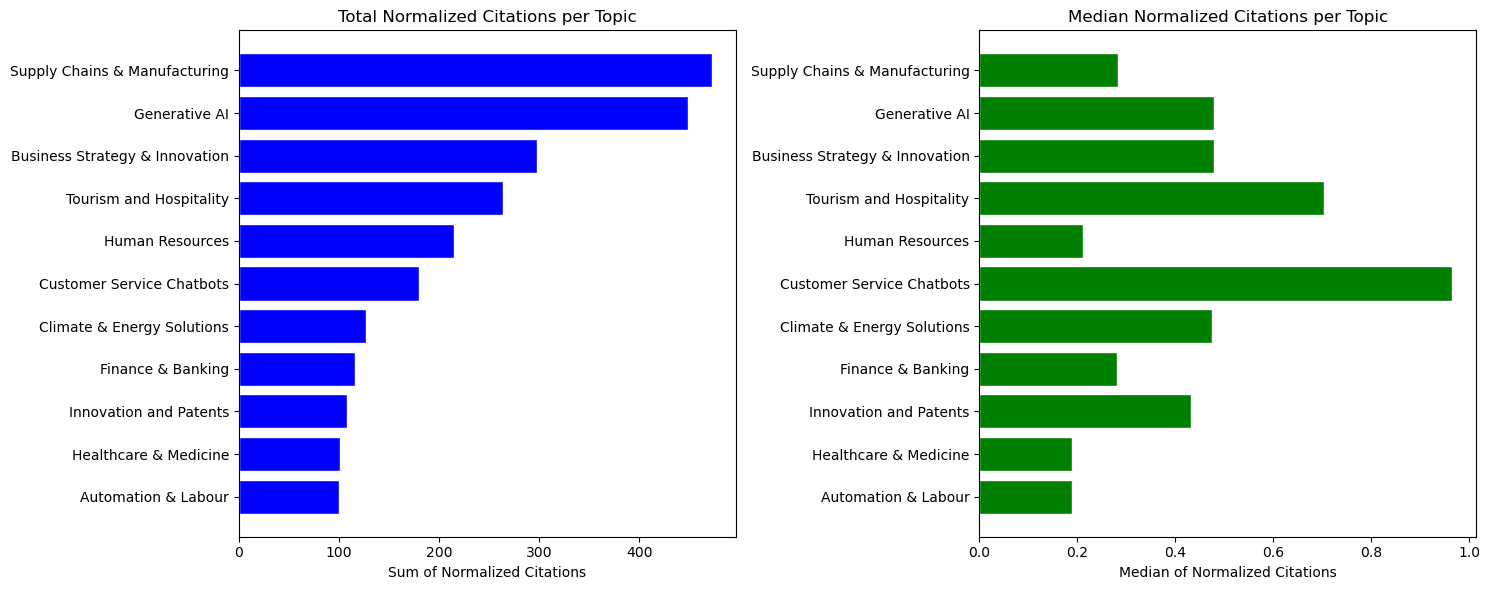

In [291]:
# group citations by year
year_avg_citations = docs_cits.groupby('Publication Year')['Cited by'].mean().reset_index()
year_avg_citations.rename(columns={'Cited by': 'avg_citations_per_year'}, inplace=True)

# Merge this information back to your original dataframe
df_with_avg = docs_cits.merge(year_avg_citations, on='Publication Year', how='left')

# Calculate normalized citations
df_with_avg['normalized_citations'] = df_with_avg['Cited by'] / df_with_avg['avg_citations_per_year']

# Merge with topic citations
df_with_avg = df_with_avg.merge(papers_topics[['abstract', 'Topic']], on='abstract', how='left')

# Now create a new topics_citations dataframe with normalized values
topics_normalized_citations = df_with_avg.groupby('Topic').agg(
    sum_norm_citations=('normalized_citations', 'sum'),
    med_norm_citations=('normalized_citations', 'median'),
    count=('normalized_citations', 'count')
).reset_index()

# Apply your labels
topics_normalized_citations['Label'] = topics_normalized_citations['Topic'].apply(lambda x: custom_topic_labels[x])
topics_normalized_citations = topics_normalized_citations[(topics_normalized_citations['Topic'] <= 10) &
                                                         (topics_normalized_citations['Topic'] != -1)]
topics_normalized_citations = topics_normalized_citations.sort_values(by='sum_norm_citations', ascending=False)

# Creating the plot with normalized citations
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Total Normalized Citations bar chart
axes[0].barh(topics_normalized_citations['Label'], topics_normalized_citations['sum_norm_citations'],
            color='blue', edgecolor="white")
axes[0].set_title("Total Normalized Citations per Topic")
axes[0].set_xlabel("Sum of Normalized Citations")
axes[0].invert_yaxis()  # Invert y-axis for better readability

# Median Normalized Citations bar chart
axes[1].barh(topics_normalized_citations['Label'], topics_normalized_citations['med_norm_citations'],
            color='green', edgecolor="white")
axes[1].set_title("Median Normalized Citations per Topic")
axes[1].set_xlabel("Median of Normalized Citations")
axes[1].invert_yaxis()  # Ensure both y-axes match

# Adjust layout and save
plt.tight_layout()
plt.show()

file_path_norm_cits = "images/pub_normalized_citations_by_topic.pdf"
fig.savefig(file_path_norm_cits, format="pdf", bbox_inches="tight")

In [292]:
# Get all questions from topic 10 (Climate & Energy Solutions), sorted by citation count
# Display the full output without truncation
pd.set_option('display.max_colwidth', None)
climate_energy_questions = papers_topics_full[papers_topics_full['Topic'] == 7].sort_values(by='Cited by', ascending=False)['Question'].head()
print(climate_energy_questions)
pd.reset_option('display.max_colwidth')  # Reset to default after displaying

3136                                                                          What are the effects of COVID-19 on hotel marketing and management practices, and what research agenda can be developed to address these challenges?
1676                                  What are the key dimensions influencing consumers' willingness to integrate artificial intelligence and service robots into hospitality and tourism services, and how can these be measured?
1176    How has the COVID-19 pandemic influenced the adoption of robotics and artificial intelligence in the travel and tourism sector, and what opportunities does this present for enhancing tourist experiences and employment?
2179                                                                    What are the key research priorities for shaping the future of intelligent automation in travel and tourism, and how can these advancements be beneficial?
1477                                                                   How does the perceive

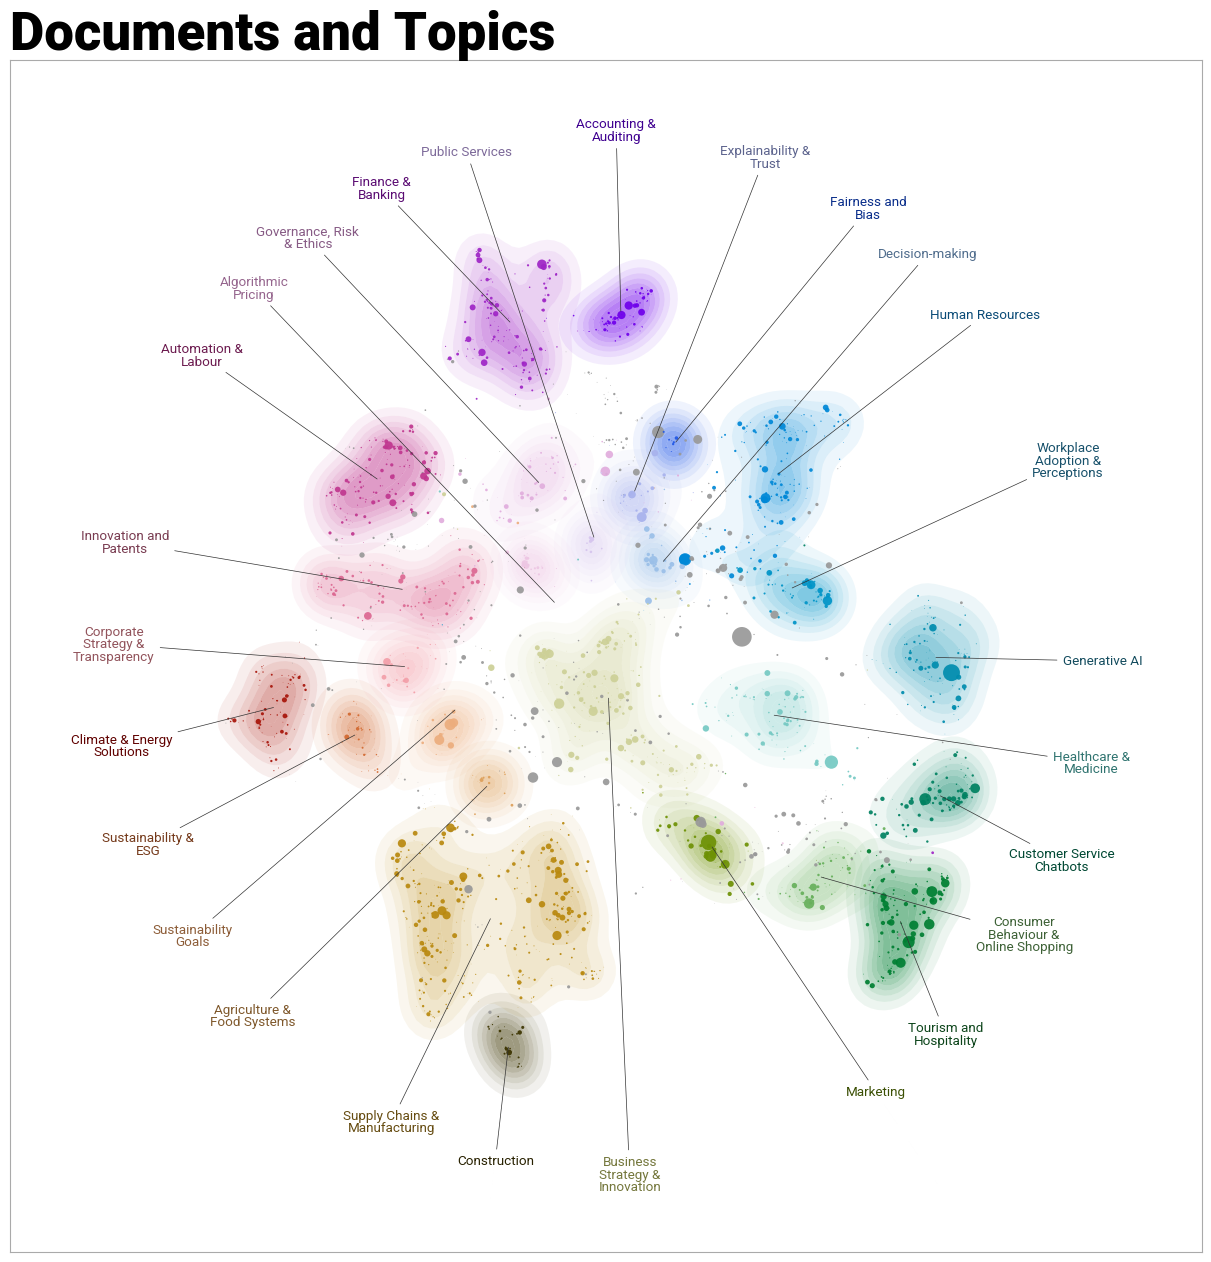

In [293]:
citations = docs_cits['Cited by'].to_list()
scaled_citations = [2*(c / max(citations)) * 100 for c in citations]
fig = topic_model.visualize_document_datamap(documents, custom_labels = True, embeddings=embeddings, point_size=scaled_citations)
fig.show()
fig.savefig("images/pub_landscape.pdf", dpi=600, bbox_inches='tight')